C:\Users\Milanjyoti\AppData\Local\Temp\ipykernel_11600\2728729628.py:34: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet_base = MobileNetV2(weights='imagenet', include_top=False, input_tensor=input_layer)


Found 406 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.
Found 103 images belonging to 3 classes.


C:\Users\Milanjyoti\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 127s 4s/step - accuracy: 0.4310 - loss: 1.9514 - val_accuracy: 0.6990 - val_loss: 0.7052
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.5218 - loss: 0.9945 - val_accuracy: 0.6311 - val_loss: 0.7938
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.5925 - loss: 0.9109 - val_accuracy: 0.7184 - val_loss: 0.6450
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.7298 - loss: 0.6555 - val_accuracy: 0.7184 - val_loss: 0.6045
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.6771 - loss: 0.7602 - val_accuracy: 0.7670 - val_loss: 0.5697
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.7881 - loss: 0.5224 - val_accuracy: 0.6602 - val_loss: 0.9102
Epoch 7/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.8278 - loss: 0.4494 - val_accuracy: 0.7379 - val_loss: 0.5483
Epoch 8/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.8021 - loss: 0.4654 - val_accuracy: 0.7476 - val_loss

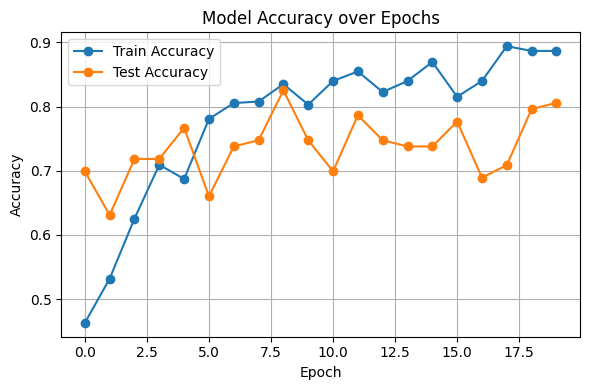

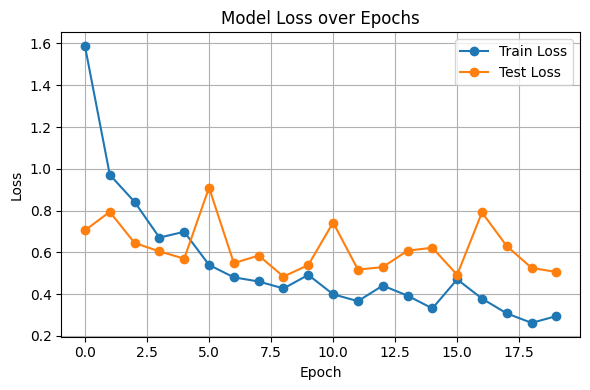

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2, ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import roc_curve, auc
import numpy as np
import os
import random

seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# Define Paths
train_dir = 'D:/Lung_cancer/train'
val_dir = 'D:/Lung_cancer/LC25000_sampled'
test_dir = 'D:/Lung_cancer/test'
num_classes = 3

# Hyperparameters
batch_size = 16
dropout_rate = 0.3
learning_rate = 0.001
image_size = (224, 224, 3)

# Define Input Layer
input_layer = layers.Input(shape=image_size)

# Load Pretrained Models
mobilenet_base = MobileNetV2(weights='imagenet', include_top=False, input_tensor=input_layer)
resnet_base = ResNet50(weights='imagenet', include_top=False, input_tensor=input_layer)

# Freeze Base Models
mobilenet_base.trainable = False
resnet_base.trainable = False

# Extract Features
mobilenet_features = layers.GlobalAveragePooling2D()(mobilenet_base.output)
resnet_features = layers.GlobalAveragePooling2D()(resnet_base.output)

# Concatenate Features
merged_features = layers.Concatenate()([mobilenet_features, resnet_features])

# Fully Connected Layers
x = layers.Dense(512, activation='relu')(merged_features)
x = layers.Dropout(dropout_rate)(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(dropout_rate)(x)
output = layers.Dense(num_classes, activation='softmax')(x)

# Define Model
model = models.Model(inputs=input_layer, outputs=output)

# Compile Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
              loss='categorical_crossentropy', metrics=['accuracy'])

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=seed   
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_generator = val_datagen.flow_from_directory(val_dir, target_size=(224, 224), 
                                                batch_size=batch_size, class_mode='categorical', shuffle=False)

test_generator = test_datagen.flow_from_directory(test_dir, target_size=(224, 224), 
                                                  batch_size=batch_size, class_mode='categorical', shuffle=False)

# Train Model
history = model.fit(train_generator, 
                    validation_data=test_generator, 
                    epochs=20,
                    verbose = 1)


# ---- Evaluate VGG19 ----
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# Evaluate for training
train_loss, train_accuracy = model.evaluate(train_generator, verbose=1)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Training Loss: {train_loss:.4f}")

# Evaluate the final model
val_loss, val_accuracy = model.evaluate(val_generator, verbose=1)
print(f"Final Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"Final Validation Loss: {val_loss:.4f}")

import numpy as np
import pickle
# ---- Save the training history as a pickle file (.pkl) ----
history_file = 'mobilenet_resnet_cv(new).pkl'

with open(history_file, 'wb') as f:
    pickle.dump(history.history, f)

print("Model training complete and history")

import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Test Accuracy', marker='o')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---- Plot Loss ----
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Test Loss', marker='o')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

94/94 ━━━━━━━━━━━━━━━━━━━━ 169s 2s/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step
🔍 Validation Data Metrics:
                    precision    recall  f1-score   support

    Adenocarcinoma       0.69      0.75      0.72       500
               Nor       0.85      0.97      0.91       500
Squamous_carcinoma       0.86      0.66      0.74       500

          accuracy                           0.79      1500
         macro avg       0.80      0.79      0.79      1500
      weighted avg       0.80      0.79      0.79      1500

🔍 Test Data Metrics:
                    precision    recall  f1-score   support

    Adenocarcinoma       0.83      0.77      0.80        39
               Nor       0.78      0.81      0.79        31
Squamous_carcinoma       0.80      0.85      0.82        33

          accuracy                           0.81       103
         macro avg       0.80      0.81      0.81       103
      weighted avg       0.81      0.81      0.81       103

Validation Accuracy: 0.793333

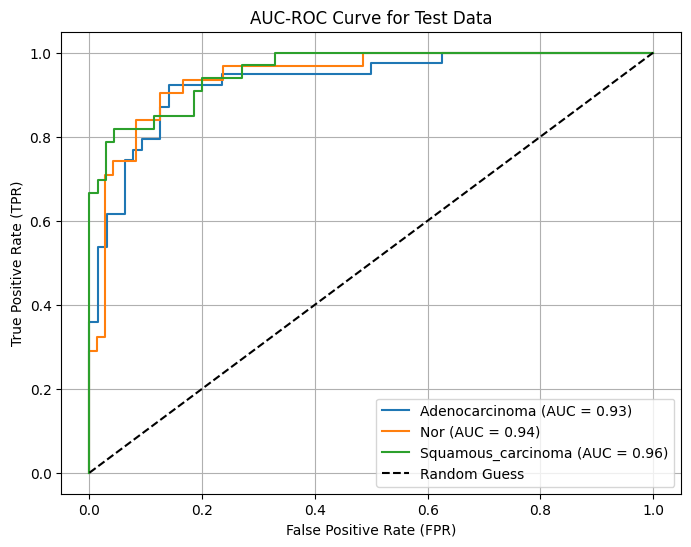


Macro-Averaged Test AUC: 0.94
94/94 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step

AUC-ROC for each class:
Adenocarcinoma - AUC: 0.89
Nor - AUC: 0.99
Squamous_carcinoma - AUC: 0.94


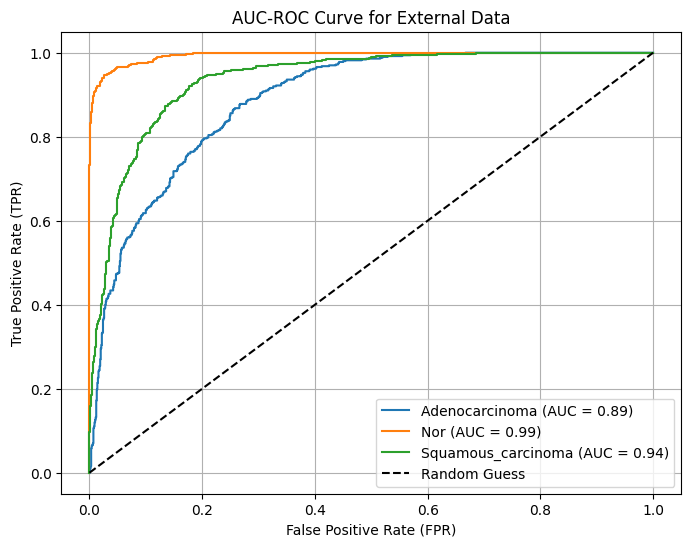


Macro-Averaged External AUC: 0.94


In [3]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
# Predicting on validation data
val_predictions = model.predict(val_generator)
val_pred_labels = np.argmax(val_predictions, axis=1)
val_true_labels = val_generator.classes

# Predicting on test data
test_predictions = model.predict(test_generator)
test_pred_labels = np.argmax(test_predictions, axis=1)
test_true_labels = test_generator.classes
print("🔍 Validation Data Metrics:")
print(classification_report(val_true_labels, val_pred_labels, target_names=val_generator.class_indices.keys()))

print("🔍 Test Data Metrics:")
print(classification_report(test_true_labels, test_pred_labels, target_names=test_generator.class_indices.keys()))

# Additional individual metrics for better control
print("Validation Accuracy:", accuracy_score(val_true_labels, val_pred_labels))
print("Validation Precision:", precision_score(val_true_labels, val_pred_labels, average='weighted'))
print("Validation Recall:", recall_score(val_true_labels, val_pred_labels, average='weighted'))
print("Validation F1-Score:", f1_score(val_true_labels, val_pred_labels, average='weighted'))

print("Test Accuracy:", accuracy_score(test_true_labels, test_pred_labels))
print("Test Precision:", precision_score(test_true_labels, test_pred_labels, average='weighted'))
print("Test Recall:", recall_score(test_true_labels, test_pred_labels, average='weighted'))
print("Test F1-Score:", f1_score(test_true_labels, test_pred_labels, average='weighted'))

# Predict probabilities for the test dataset
test_predictions =model.predict(test_generator, verbose=1)

# True labels from the test generator
test_true_labels = test_generator.classes  # True class labels
class_labels = list(test_generator.class_indices.keys())  # Class names

# Binarize the true labels for multi-class
from sklearn.preprocessing import label_binarize
test_true_labels_binarized = label_binarize(test_true_labels, classes=range(len(class_labels)))

# Compute and print AUC for each class
from sklearn.metrics import roc_curve, auc

print("\nAUC-ROC for each class:")

for i in range(len(class_labels)):
    fpr, tpr, _ = roc_curve(test_true_labels_binarized[:, i], test_predictions[:, i])
    roc_auc = auc(fpr, tpr)
    print(f"{class_labels[i]} - AUC: {roc_auc:.2f}")

# Plot ROC curves
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
for i in range(len(class_labels)):
    fpr, tpr, _ = roc_curve(test_true_labels_binarized[:, i], test_predictions[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_labels[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title('AUC-ROC Curve for Test Data')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend()
plt.grid()
plt.show()

# Compute macro-average AUC
from sklearn.metrics import roc_auc_score
macro_roc_auc = roc_auc_score(test_true_labels_binarized, test_predictions, average="macro")
print(f"\nMacro-Averaged Test AUC: {macro_roc_auc:.2f}")

# Predict probabilities for the test dataset
val_predictions =model.predict(val_generator, verbose=1)

# True labels from the test generator
val_true_labels = val_generator.classes  # True class labels
class_labels = list(val_generator.class_indices.keys())  # Class names

# Binarize the true labels for multi-class
from sklearn.preprocessing import label_binarize
val_true_labels_binarized = label_binarize(val_true_labels, classes=range(len(class_labels)))

# Compute and print AUC for each class
from sklearn.metrics import roc_curve, auc

print("\nAUC-ROC for each class:")

for i in range(len(class_labels)):
    fpr, tpr, _ = roc_curve(val_true_labels_binarized[:, i], val_predictions[:, i])
    roc_auc = auc(fpr, tpr)
    print(f"{class_labels[i]} - AUC: {roc_auc:.2f}")

# Plot ROC curves
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
for i in range(len(class_labels)):
    fpr, tpr, _ = roc_curve(val_true_labels_binarized[:, i], val_predictions[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_labels[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title('AUC-ROC Curve for External Data')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend()
plt.grid()
plt.show()

# Compute macro-average AUC
from sklearn.metrics import roc_auc_score
macro_roc_auc = roc_auc_score(val_true_labels_binarized, val_predictions, average="macro")
print(f"\nMacro-Averaged External AUC: {macro_roc_auc:.2f}")